In [1]:
import pandas as pd
import os, re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree, svm, preprocessing
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, PrecisionRecallDisplay
import seaborn as sns
from timeit import default_timer as timer
import random
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.model_selection import GridSearchCV, cross_val_score
import statistics

pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 200)
pd.set_option('display.expand_frame_repr', True)
pd.options.mode.chained_assignment = None

projDir = '/home'
rawDataDir = projDir + '/raw_data'
processedDataDir = projDir + '/processed_data'

def check_ALPHA_distribution(df):
    # plotting a histogram
    plt.hist(df["ALPHA"])
    plt.show()

    num_obs_alerts = df[df["ALPHA"] == 1].shape[0]
    num_obs_no_alerts = df[df["ALPHA"] == 0].shape[0]
    tot_obs = df.shape[0]

    pct_no_alert = num_obs_no_alerts/tot_obs*100
    pct_alert = num_obs_alerts/tot_obs*100

    print(f"There are {pct_no_alert:.2f}% ({num_obs_no_alerts}/{tot_obs}) observations without ALPHA Alert vs {pct_alert:.2f}% ({num_obs_alerts}/{tot_obs}) with one.")

### Load and merge all the data files into a single dataframe

In [2]:
def load_n_merge_data(tgt_endDate = '2021-10-10', tgt_numDays = '90', tgt_mkt_list = list(range(56, 75)), tgt_mkt = None):
    load_start = timer()
    file_list = [x[0] for x in os.walk(processedDataDir)]
    li = []
    for each_dir in file_list:
        if '.ipynb_checkpoints' in each_dir:
            continue
        each_file = os.listdir(each_dir)
        for file in each_file:
            if file == '.ipynb_checkpoints':
                continue
            elif 'cleaned_alerting_cells' in file:
                continue
            mkt_regex = r'.*?(\d{1,3})_\d{4}'
            mkt = re.search(mkt_regex, file)
            mkt = (mkt.group(1))

            date_regex = r'.*?\d{1,3}_(\d{4}-\d{2}-\d{2})_'
            date = re.search(date_regex, file)
            date = (date.group(1))        
            date_stamp = datetime.strptime(date, '%Y-%m-%d')
            date = date

            num_days_regex = r'.*?_\d{4}-\d{2}-\d{2}_(\d{1,3})_shifted_kpis.csv'
            num_days = re.search(num_days_regex, file)
            num_days = (num_days.group(1))

            if int(mkt) in tgt_mkt_list and tgt_endDate == date and tgt_numDays == num_days:
                if tgt_mkt is None:
                    #print(mkt, date, num_days)
                    #tmp_df = pd.read_parquet(each_dir + '/' + file)
                    tmp_df = pd.read_csv(each_dir + '/' + file)
                    #print(tmp_df['MARKET'].unique())
                    li.append(tmp_df)
                else:
                    if mkt == tgt_mkt:
                        #tmp_df = pd.read_parquet(each_dir + '/' + file)
                        tmp_df = pd.read_csv(each_dir + '/' + file)

    if tgt_mkt is not None:
        xlptDf = tmp_df
    else:
        xlptDf = pd.concat(li, axis=0, ignore_index=True)
    load_end = timer()
    print(f"It took {((load_end - load_start)/60):.2f} minutes to load {xlptDf.shape[0]} rows of data from {len(li)} markets.")
    li.clear()
    return xlptDf

xlptDf = load_n_merge_data(tgt_endDate = '2021-10-10', tgt_numDays = '90', tgt_mkt_list = list(range(56, 75)), tgt_mkt = None)

It took 1.47 minutes to load 5158896 rows of data from 15 markets.


### The dataset is now loaded, time to clean up any duplicates and then check the ratio of negtive to postive events and downsample as needed

In [3]:
# check for duplicates and remove them
before_row_cnt = xlptDf.shape[0]
print("Shape of df before removing duplicates", xlptDf.shape)

# dropping ALL duplicate values
xlptDf = xlptDf.drop_duplicates()

after_row_cnt = xlptDf.shape[0]
print("Shape of df after removing duplicates",xlptDf.shape)

print("There were",before_row_cnt-after_row_cnt,"duplicate rows found.")

Shape of df before removing duplicates (5158896, 130)
Shape of df after removing duplicates (5157576, 130)
There were 1320 duplicate rows found.


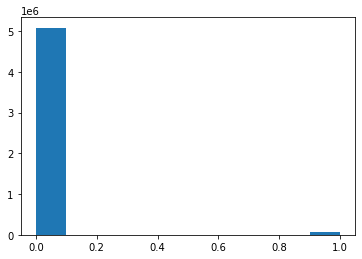

There are 98.51% (5080620/5157576) observations without RSSI Alert vs 1.49% (76956/5157576) with one.
There are 2737 cells with an alert, and 56442 without out of 59179 total cells


In [4]:
# Analyze the data and see if we need to clean anything else up
check_ALPHA_distribution(xlptDf)

total_cells = list(xlptDf["CellId"].unique())
distinct_cells_with_ALPHA = list(xlptDf[xlptDf["ALPHA"] == 1]["CellId"].unique())
distinct_cells_without_ALPHA = list(xlptDf[~xlptDf["CellId"].isin(distinct_cells_with_ALPHA)]["CellId"].unique())
print(f"There are {len(distinct_cells_with_ALPHA)} cells with an alert, and {len(distinct_cells_without_ALPHA)} without out of {len(total_cells)} total cells")

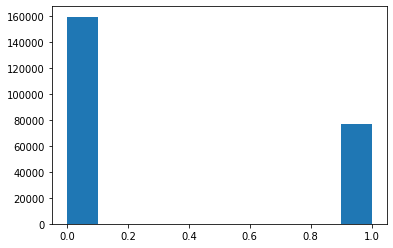

There are 67.42% (159239/236195) observations without RSSI Alert vs 32.58% (76956/236195) with one.
There are 2737 cells with an alert now in our dataset


In [5]:
# too many negative examples

# Make a new dataframe using all the records from the cells with at least one ALPHA and then check the distribution of alerts again.
ALPHA_cells_only_df = xlptDf[xlptDf["CellId"].isin(distinct_cells_with_ALPHA)]
check_ALPHA_distribution(ALPHA_cells_only_df)
print(f"There are {len(ALPHA_cells_only_df['CellId'].unique())} cells with an alert now in our dataset")

In [6]:
# a 67/33 split on neg to pos events is enough to move forward with normalization

# generate a list of random cells to use to run quick analysis
rand_100_cells = random.sample(distinct_cells_with_ALPHA, 100)


df_active = ALPHA_cells_only_df
# df_active = two_cells
# print(list(df_active.columns))

### Get the list of features from the dataset we wish to train on

In [7]:
df_active_cols = list(df_active.columns)
# print(df_active_cols)
not_features = ['Unnamed: 0', 'ALPHADelta', 'Year', 'Month', 'WeekOfYear', 'Adjusted_SIP_SC_DC%_pct_change', 'AvgNoiseIntensity_pct_change', 'DLVoLTEHARQFailRate_pct_change', 'SEA_CAConfigurationFailure_%_pct_change', 'SEA_CAULDataVolumeRatio_%_pct_change', 'SEA_ContextDropRate_%_pct_change', 'SEA_ContextSetupFailure_%_pct_change', 'SEA_DLInitBLER_%_pct_change', 'SEA_DLMACLayerDataVolume_MB_pct_change', 'SEA_DLPDCPLayerDataVolumeQCI8_MB_pct_change', 'SEA_DLPDCPLayerDataVolumeQCI9_MB_pct_change', 'SEA_DLPRBUtilization_%_pct_change', 'SEA_DLRLCLayerDataVolumeQCI8_MB_pct_change', 'SEA_DLRLCLayerDataVolumeQCI9_MB_pct_change', 'SEA_DLRLCReTx_%_pct_change', 'SEA_DLResidualBLER_%_pct_change', 'SEA_DLTTIUtilization_%_pct_change', 'SEA_DLUserPerceivedTputQCI8_Mbps_pct_change', 'SEA_DLUserPerceivedTputQCI9_Mbps_pct_change', 'SEA_DLUserPerceivedTput_Mbps_pct_change', 'SEA_DefaultERABDropRate_%_pct_change', 'SEA_DefaultERABSetupFailureRate_%_pct_change', 'SEA_ERABDropRateQCI1_%_pct_change', 'SEA_ERABDropRateQCI8_%_pct_change', 'SEA_ERABDropRateQCI9_%_pct_change', 'SEA_ERABSetupFailureRateQCI1_%_pct_change', 'SEA_InterFreqBlindRedirectionRate_%_pct_change', 'SEA_InterFreqHOFailRate_%_pct_change', 'SEA_IntraFreqHOFailRate_%_pct_change', 'SEA_MIMOElgibilityRatio_%_pct_change', 'SEA_RRCConnectionBlocked_%_pct_change', 'SEA_RRCConnectionDropRate_%_pct_change', 'SEA_RRCReestFailureRate_%_pct_change', 'SEA_RRCReestablishmentRate_%_pct_change', 'SEA_RRCSetupFailure_%_pct_change', 'SEA_TTIBActivationFailureRate_%_pct_change', 'SEA_TTIBActivationRate_%_pct_change', 'SEA_TotalDLPDCPLayerDataVolume_MB_pct_change', 'SEA_TotalDLRLCLayerDataVolume_MB_pct_change', 'SEA_TotalERABDropRate_%_pct_change', 'SEA_TotalERABSetupFailureRate_%_pct_change', 'SEA_UEPwrHeadroom_dB_pct_change', 'SEA_ULInitBLER_%_pct_change', 'SEA_ULPDCPPacketLossRate_%_pct_change', 'SEA_ULPRBUtilization_%_pct_change', 'SEA_ULResidualBLER_%_pct_change', 'SEA_ULTTIUtilization_%_pct_change', 'SEA_ULUserPerceivedTput_Mbps_pct_change', 'SEA_VoLTETTIBPRBUtilization_%_pct_change', 'SEA_VoLTE_AverageCQI_pct_change', 'SEA_VoLTE_HOFailRate_%_pct_change', 'SEA_VoLTE_IARate_%_pct_change', 'SEA_VoLTE_SFRate_%_pct_change', 'SEA_VoLTE_ULPDCPPacketLossRate_%_pct_change', 'SEA_VoLTE_ULPRBUtilization_%_pct_change', 'SEA_VoLTE_ULResidualBLER_%_pct_change', 'SEA_X2HOFailRate_%_pct_change', 'ULVoLTEHARQFailRate_pct_change', 'ALPHA_tomorrow', 'ALPHA_yesterday']
do_not_scale = ['DOW', 'WeekEnd', 'WeekOfYear', 'ALPHA_tomorrow', 'ALPHA_yesterday']
do_not_scale = do_not_scale + not_features
features = np.setdiff1d(df_active_cols, do_not_scale)
# print(features)

In [8]:
# we need to remove infinite values from the data
df_active.replace([np.inf, -np.inf], 999, inplace=True)

### Test/train splitting and scaling of data

In [9]:
# prepare data for modeling - scale over all cells
def Build_Data_Set(data_df, FEATURES, response, test_size, norm=True):             
    data_df = data_df[:2000]
    X = data_df[FEATURES] # Features
    y = data_df[response].values # Target variable
    
    # split into train test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    
    std_scale = preprocessing.MinMaxScaler().fit(X_train)
    X_train = std_scale.transform(X_train)
    X_test  = std_scale.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# prepare data for modeling - this time scale the features groupped a the cell level
def Build_Data_Set_pre_norm(data_df, FEATURES, response, test_size, norm=True):     
#     print(data_df.shape)
    # limit the training to just the first N rows for speed sake
    data_df = data_df.sample(n=10000, random_state = 2)
#     print(data_df.shape)
    # split the dataframes into test and train size to normalize each
    rows = len(data_df)
    
    # Creating a test dataframe with test_size% values of original dataframe
    test_df = data_df.sample(frac=test_size, random_state = 2)

    # Creating training dataframe with rest of the 100-test_size% values
    train_df = data_df.drop(test_df.index)
    
    #print(f'There are {rows} observations, will train on {len(train_df)} and test on {len(test_df)} and train + test = {len(test_df)+len(train_df)}')
    
    #normalize the dataframes 
    train_cells = list(train_df['CellId'].unique())
    test_cells = list(test_df['CellId'].unique())
    
    # Creating an instance of the sklearn.preprocessing.MinMaxScaler()
    scaler = preprocessing.MinMaxScaler()
    
    li = []
    for cell in train_cells:
        df = train_df[train_df['CellId'] == cell]
        df[FEATURES] = scaler.fit_transform(df[FEATURES])
        li.append(df)
        
    norm_train_df = pd.concat(li, axis=0, ignore_index=True)
    li.clear()
    
    li = []
    for cell in test_cells:
        df = test_df[test_df['CellId'] == cell]
        df[FEATURES] = scaler.fit_transform(df[FEATURES])
        li.append(df)
        
    norm_test_df = pd.concat(li, axis=0, ignore_index=True)
    li.clear()
    
    X_train = norm_train_df[FEATURES].to_numpy()
    X_test = norm_test_df[FEATURES].to_numpy()
    y_train = norm_train_df[response].values
    y_test = norm_test_df[response].values
        
    return X_train, X_test, y_train, y_test
build_start = timer()

# split into train test sets
X_train, X_test, y_train, y_test = Build_Data_Set_pre_norm(df_active, features, 'ALPHA', test_size=0.2)
build_end = timer()
print(f"It took {((build_end - build_start)/60):.2f} minutes to build our numpy array's for training.")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


It took 0.43 minutes to build our numpy array's for training.
(8000, 58) (2000, 58) (8000,) (2000,)


# Model training
### Logistic Regression -  With 5 Fold Cross Validation

It took 0.06 minutes to train and predict our LogisticRegression model.
Our LogisticRegression model has an accuracy of 0.6685 with precision 0.5883 and recall 0.5175
Train n= 8000 Test n= 2000


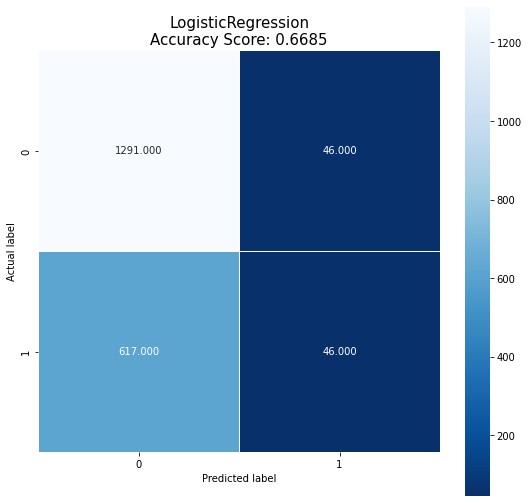

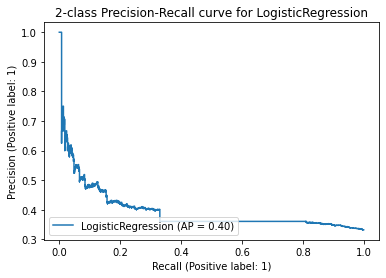

In [10]:
mdl = 'LogisticRegression'
train_start = timer()

# classifer object, For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
clf = LogisticRegressionCV(cv=5, random_state=2, solver='newton-cg').fit(X_train,y_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
train_end = timer()
print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our {mdl} model.")

# Model Accuracy, how often is the classifier correct?
score = clf.score(X_test, y_test)
print(f"Our {mdl} model has an accuracy of {score:.4f} with precision {precision_score(y_test, y_pred_test, average='macro'):.4f} and recall {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print("Train n=", len(X_train), "Test n=", len(X_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'{mdl}\nAccuracy Score: {score}'
plt.title(all_sample_title, size = 15);

display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=mdl)
_ = display.ax_.set_title(f"2-class Precision-Recall curve for {mdl}")

# save the model to disk
filename = projDir + f'/models/{mdl}.pickle'
pickle.dump(clf, open(filename, 'wb'))


With 66.85% accuracy, Logistic Regression does not seem to be a great fit for our multi-class dataset.

## Linear Discriminant Analysis

It took 0.00 minutes to train and predict our LinearDiscriminantAnalysis model.
Our LinearDiscriminantAnalysis model has an accuracy of 0.6675 with precision 0.5852 and recall 0.5217
Train n= 8000 Test n= 2000


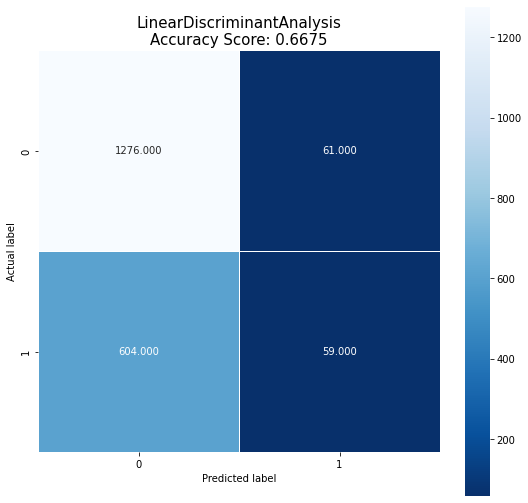

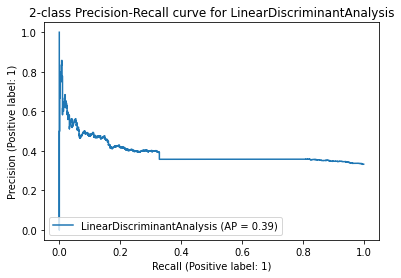

In [11]:
mdl = 'LinearDiscriminantAnalysis'
train_start = timer()

# classifer object, ‘svd’: Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.
clf = LinearDiscriminantAnalysis(solver='svd').fit(X_train,y_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
train_end = timer()
print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our {mdl} model.")

# Model Accuracy, how often is the classifier correct?
score = clf.score(X_test, y_test)
print(f"Our {mdl} model has an accuracy of {score:.4f} with precision {precision_score(y_test, y_pred_test, average='macro'):.4f} and recall {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print("Train n=", len(X_train), "Test n=", len(X_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'{mdl}\nAccuracy Score: {score}'
plt.title(all_sample_title, size = 15);

display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=mdl)
_ = display.ax_.set_title(f"2-class Precision-Recall curve for {mdl}")

# save the model to disk
filename = projDir + f'/models/{mdl}.pickle'
pickle.dump(clf, open(filename, 'wb'))

With 66.75% accuracy, Linear Discriminant Analysis does not seem to have decreased much over Logistic Regression.

## Quadratic Discriminant Analysis

/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


It took 0.00 minutes to train and predict our QuadraticDiscriminantAnalysis model.
Our QuadraticDiscriminantAnalysis model has an accuracy of 0.6510 with precision 0.5545 and recall 0.5261
Train n= 8000 Test n= 2000


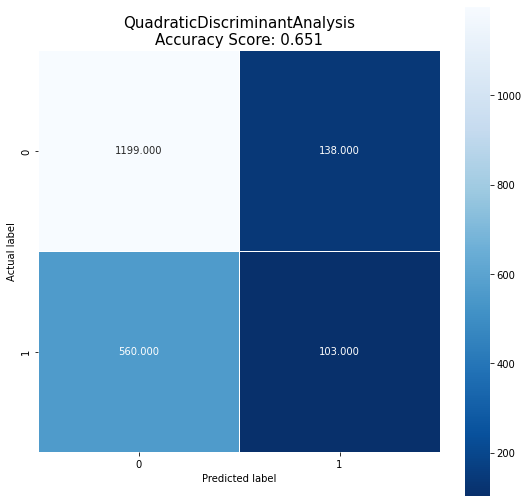

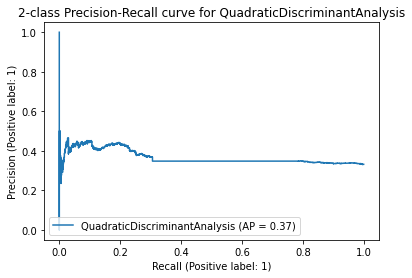

In [12]:
mdl = 'QuadraticDiscriminantAnalysis'
train_start = timer()

# classifer object
clf = QuadraticDiscriminantAnalysis().fit(X_train,y_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
train_end = timer()
print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our {mdl} model.")

# Model Accuracy, how often is the classifier correct?
score = clf.score(X_test, y_test)
print(f"Our {mdl} model has an accuracy of {score:.4f} with precision {precision_score(y_test, y_pred_test, average='macro'):.4f} and recall {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print("Train n=", len(X_train), "Test n=", len(X_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'{mdl}\nAccuracy Score: {score}'
plt.title(all_sample_title, size = 15);

display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=mdl)
_ = display.ax_.set_title(f"2-class Precision-Recall curve for {mdl}")

# save the model to disk
filename = projDir + f'/models/{mdl}.pickle'
pickle.dump(clf, open(filename, 'wb'))

With the worse accuracy of 65.10%, Quadratic Discriminant Analysis is worse, and it informs us of collinearity in our features.  This is expected, as often in this problem space a change in one will result in a change in another.

## K-Nearest Neighbors - With 10 Fold Cross Validation

It took 2.04 minutes to train and predict our K-NearestNeighbors-63 model.
Our K-NearestNeighbors-63 model has an accuracy of 0.6790 and a 10 fold cv score of 0.6791 with precision 0.6962 and recall 0.5212
Train n= 8000 Test n= 2000


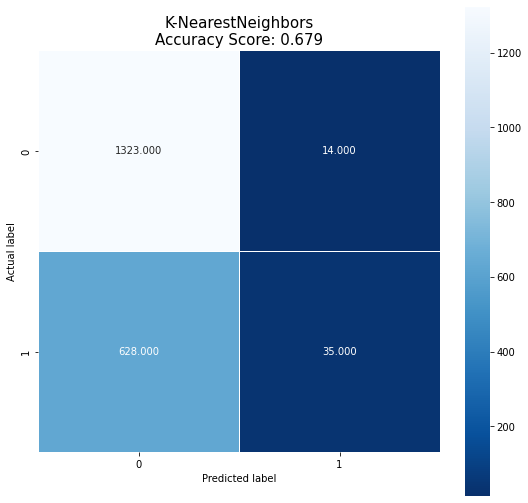

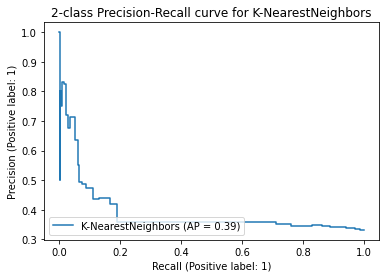

In [13]:
mdl = 'K-NearestNeighbors'
train_start = timer()

#create new a knn model
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=10)

#fit model to data
knn_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
best = knn_gscv.best_params_

#check mean score for the top performing value of n_neighbors
scoreCV = knn_gscv.best_score_

# now that we have our best CV verified model, let's use it to predict.

# classifer object
clf = KNeighborsClassifier(n_neighbors=best['n_neighbors']).fit(X_train,y_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
train_end = timer()
print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our {mdl}-{best['n_neighbors']} model.")

# Model Accuracy, how often is the classifier correct?
score = clf.score(X_test, y_test)
print(f"Our {mdl}-{best['n_neighbors']} model has an accuracy of {score:.4f} and a 10 fold cv score of {scoreCV:.4f} with precision {precision_score(y_test, y_pred_test, average='macro'):.4f} and recall {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print("Train n=", len(X_train), "Test n=", len(X_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'{mdl}\nAccuracy Score: {score}'
plt.title(all_sample_title, size = 15);

display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=mdl)
_ = display.ax_.set_title(f"2-class Precision-Recall curve for {mdl}")

# save the model to disk
nn = best['n_neighbors']
filename = projDir + f'/models/{mdl}-{nn}.pickle'
pickle.dump(clf, open(filename, 'wb'))


#### I had written my own attempt to do the above code below before I found GridSearchCV!!! ####
# k_range = [*range(1, 100, 1)]
# scores = {}
# for k in k_range:
#     # classifer object
#     clf = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)

#     #Predict the response for test dataset
#     y_pred_test = clf.predict(X_test)
#     y_pred_train = clf.predict(X_train)
#     train_end = timer()
# #     print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our {mdl} model.")

#     scores[k] = clf.score(X_test, y_test)
# #     print(f"Our {mdl} model has an accuracy of {score}")

# max_k = max(scores, key=scores.get)
# max_accuracy = max(scores.values())



After running a simulation of 100 values of K from 1-100, I found that using a K = 64 provided the best accuracy of 67.9%.  This model took 2.5 minutes to train, and  provided margianl improvement over Logistic Regression.

## Decision Tree Classifier - 10 Fold Cross Validation - Without Pruning

It took 0.03 minutes to train and predict our Tree.
Our DecisionTreeClassifier model has an accuracy of 0.6065 and a 10 fold cv score of 0.5805 with precision 0.4954 and recall 0.4970
Train n= 8000 Test n= 2000


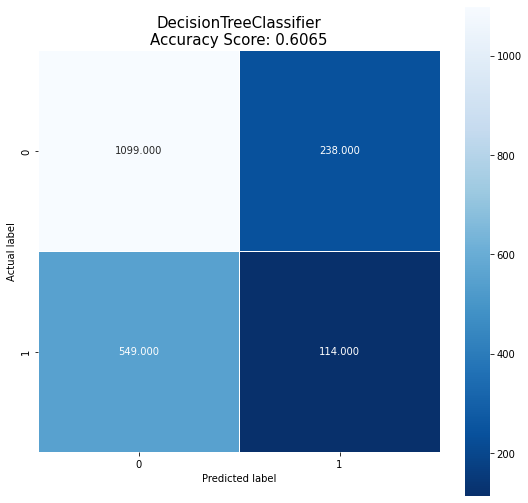

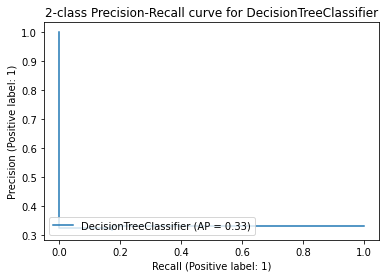

In [14]:
mdl = 'DecisionTreeClassifier'
train_start = timer()

# classifer object
clf_tree = tree.DecisionTreeClassifier(random_state=0)

# Train Decision Tree Classifer
clf = clf_tree.fit(X_train,y_train)

# check cross validation
scoreCV = statistics.mean(cross_val_score(clf_tree, X_train,y_train, cv=10))

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
train_end = timer()
print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our Tree.")

# Model Accuracy, how often is the classifier correct?
score = clf.score(X_test, y_test)
print(f"Our {mdl} model has an accuracy of {score:.4f} and a 10 fold cv score of {scoreCV:.4f} with precision {precision_score(y_test, y_pred_test, average='macro'):.4f} and recall {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print("Train n=", len(X_train), "Test n=", len(X_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'{mdl}\nAccuracy Score: {score}'
plt.title(all_sample_title, size = 15);

display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=mdl)
_ = display.ax_.set_title(f"2-class Precision-Recall curve for {mdl}")

# save the model to disk
filename = projDir + f'/models/{mdl}.pickle'
pickle.dump(clf, open(filename, 'wb'))

With an accuracy of 60.65%, this tree is by far the worst model yet.  It's precision and recall are both below 50% as well.  We should try to prune, but I expect if the tree already is not doing well that pruning may not help.

## Decision Tree Classifier - 10 Fold Cross Validation - Pruning

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0048882376799341265


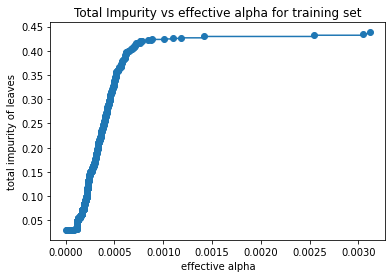

In [15]:
mdl = 'DecisionTreeClassifier_pruned'
train_start = timer()

# classifer object
clf_tree = tree.DecisionTreeClassifier(random_state=0)

# Train Decision Tree Classifer
path = clf_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first.
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# Next, we train a decision tree using the effective alphas.
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

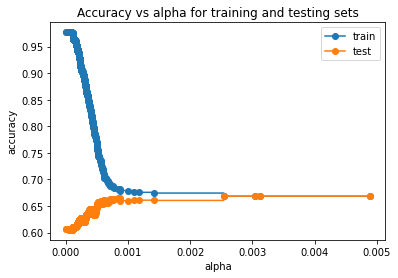

In [16]:
# Plot the alpha's vs their accuracy to pick the one that best addresses the bias-varriance tradeoff
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

It took 0.03 minutes to train and predict our Tree.
Our DecisionTreeClassifier_ccp_alpha_0.00141585878 model has an accuracy of 0.6610 and a 10 fold cv score of 0.6685 with precision 0.5651 and recall 0.5210
Train n= 8000 Test n= 2000


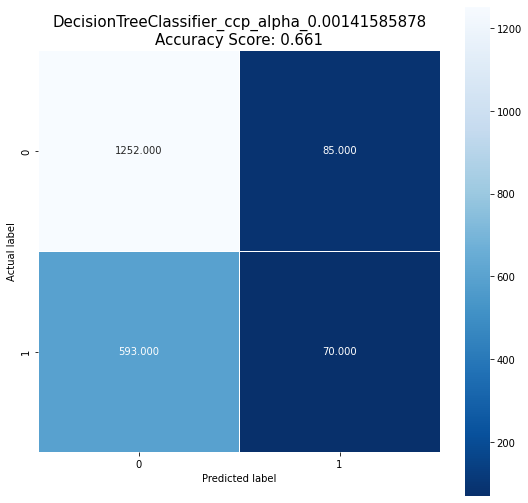

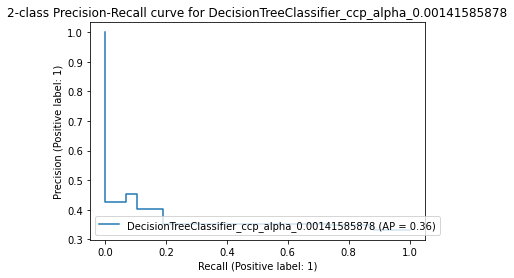

In [17]:
# We need to choose an alpha near the training elbow.  There is one just below 0.002 and one just above it.  Taking the value where the test and train error are the same would be overfitting.
mdl = 'DecisionTreeClassifier_ccp_alpha_0.00141585878'
train_start = timer()

# classifer object
clf_tree = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=1.41585878e-03)

# Train Decision Tree Classifer
clf = clf_tree.fit(X_train,y_train)

# check cross validation
scoreCV = statistics.mean(cross_val_score(clf_tree, X_train,y_train, cv=10))

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
train_end = timer()
print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our Tree.")

# Model Accuracy, how often is the classifier correct?
score = clf.score(X_test, y_test)
print(f"Our {mdl} model has an accuracy of {score:.4f} and a 10 fold cv score of {scoreCV:.4f} with precision {precision_score(y_test, y_pred_test, average='macro'):.4f} and recall {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print("Train n=", len(X_train), "Test n=", len(X_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'{mdl}\nAccuracy Score: {score}'
plt.title(all_sample_title, size = 15);

display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=mdl)
_ = display.ax_.set_title(f"2-class Precision-Recall curve for {mdl}")

# save the model to disk
filename = projDir + f'/models/{mdl}.pickle'
pickle.dump(clf, open(filename, 'wb'))

With an accuracy of 66.10% with a pruned model up from 60.65%, this tree is still not great as expected.  Let's try one last model to see if this problem can be solved.

## Support Vector Machine

In [20]:
mdl = 'SupportVectorMachine'
train_start = timer()


#create a dictionary of all standar values we want to test
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

# recursively search for the best SVC parameters to set and print the best estimator
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  13.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  12.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  13.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  13.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  14.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.1s
[CV] END .....................C=0.1, gamma=1, k

It took 18.96 minutes to train and predict our SupportVectorMachine-63 model.
Our SupportVectorMachine model has an accuracy of 0.6745 and a 10 fold cv score of 0.6820 with precision 0.6355 and recall 0.5189
Train n= 8000 Test n= 2000


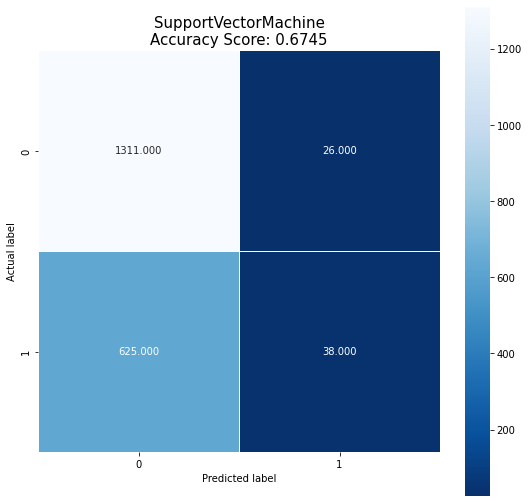

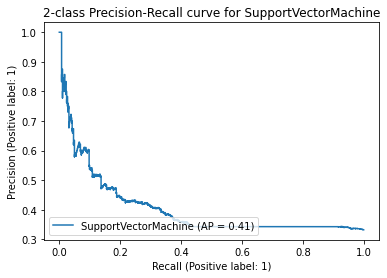

In [21]:
# now that we've recusively found the best model, assign that and predict on the whole test set
mdl = 'SupportVectorMachine'

# classifer object
clf = grid.best_estimator_

# check cross validation
scoreCV = statistics.mean(cross_val_score(clf, X_train,y_train, cv=10))

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
train_end = timer()
print(f"It took {((train_end - train_start)/60):.2f} minutes to train and predict our {mdl}-{best['n_neighbors']} model.")

# Model Accuracy, how often is the classifier correct?
score = clf.score(X_test, y_test)
print(f"Our {mdl} model has an accuracy of {score:.4f} and a 10 fold cv score of {scoreCV:.4f} with precision {precision_score(y_test, y_pred_test, average='macro'):.4f} and recall {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print("Train n=", len(X_train), "Test n=", len(X_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'{mdl}\nAccuracy Score: {score}'
plt.title(all_sample_title, size = 15);

display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, name=mdl)
_ = display.ax_.set_title(f"2-class Precision-Recall curve for {mdl}")

# save the model to disk
filename = projDir + f'/models/{mdl}.pickle'
pickle.dump(clf, open(filename, 'wb'))

After running 48 simulation to tune the SVC, I found that using a C=1, gamma=0.1 provided the best accuracy of 67.45%.  This model took 19 minutes to train, and  provided marginal improvement over Logistic Regression as well.

### Summary
I've trained and tested multiple models in my analysis.  This notebook speaks for itself, so please see my Project Report for summary statments and insights.